# Comparisons with existing ML solutions

You must run this notebook only if the notebook [`01-prepare-data.ipynb`](./01-prepare-data.ipynb) has been ran.
We rely on the existence of the pre-processed dataset files to run the model.

## Data preparation

First, we load the dataset from the CSV

In [1]:
import pandas as pd

data = pd.read_csv('data/reduced_dataset.csv')
print(data.head())

   Seating Capacity  Average Meal Price  Weekend Reservations  \
0                38               73.98                    13   
1                76               28.11                    48   
2                48               48.29                    27   
3                34               51.55                     9   
4                88               75.98                    37   

   Weekday Reservations     Revenue  Marketing&Followers  Location_Downtown  \
0                     4   638945.52            -0.870544              False   
1                     6   490207.83             0.712762               True   
2                    14   541368.62            -0.122085              False   
3                    17   404556.80            -1.591078              False   
4                    26  1491046.35             0.314123               True   

   Location_Rural  Location_Suburban  Cuisine_American  Cuisine_French  \
0            True              False             False      

After loading the data, we need to perform some immediate pre-processing. We cannot (in a simple way) load the already scaled values from the dataset, as we'll not be able to descale them back (in a simple way), so let's scale the columns right here.

We have the boolean and integer values in our dataset, need to convert everything to a consistent data type.

In [2]:
data = data.astype(float)
print(data.head())

   Seating Capacity  Average Meal Price  Weekend Reservations  \
0              38.0               73.98                  13.0   
1              76.0               28.11                  48.0   
2              48.0               48.29                  27.0   
3              34.0               51.55                   9.0   
4              88.0               75.98                  37.0   

   Weekday Reservations     Revenue  Marketing&Followers  Location_Downtown  \
0                   4.0   638945.52            -0.870544                0.0   
1                   6.0   490207.83             0.712762                1.0   
2                  14.0   541368.62            -0.122085                0.0   
3                  17.0   404556.80            -1.591078                0.0   
4                  26.0  1491046.35             0.314123                1.0   

   Location_Rural  Location_Suburban  Cuisine_American  Cuisine_French  \
0             1.0                0.0               0.0      

Now we rescale the inputs, but there exist a catch.
To properly calculate the absolute error, we need original, unscaled values of the output.

But we split the dataset to training and testing sections at random.

These two processes - rescaling and train/test splitting interfere with each other.
So, we will use the simplest good enough approach: we rescale everything and will perform all operations on scaled data.

Only when there's a need to calculate the errors, we will de-scale both the predicted outputs and test outputs using the same scaler as we used for scaling.
This is not exactly the same as using the original untouched data due to rounding errors, but it's good enough to calculate the errors.

If we want to actually *use* the model for actual predictions based on user-submitted values, we'll need to keep the scaling parameters together with all the model parameters, because we'll need to scale the user-provided input and then de-scale the predicted output before returning to the user.

In [3]:
from sklearn.preprocessing import StandardScaler
# this will be kept in memory and re-used later to de-normalize the outputs
scaler = StandardScaler()

# list of columns ONLY for the REDUCED dataset
columns_to_normalize = ['Seating Capacity', 'Average Meal Price', 'Weekend Reservations', 'Weekday Reservations']
data[columns_to_normalize] = scaler.fit_transform(data[columns_to_normalize])
# print(data.head())

revenue_scaler = StandardScaler()
scaled_revenues = revenue_scaler.fit_transform(data['Revenue'].values.reshape(-1, 1))
#scaled_revenues

data['Revenue'] = scaled_revenues


OK now let's split the dataset to training and testing 80:20

In [4]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)


After splitting the dataset, we need to split them further to inputs and outputs. Here we immediately translate Pandas data frames to Numpy arrays using the `.values` property, as our `NeuralNet` object operates on Numpy arrays.

## Scikit

First, let's use the multi-linear regression from scikit-learn

In [5]:
from sklearn.linear_model import LinearRegression

# Separate the inputs and outputs
X_train = train_data.drop(columns=['Revenue']).values
y_train = train_data['Revenue'].values
X_test = test_data.drop(columns=['Revenue']).values
y_test = test_data['Revenue'].values

# Create and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test).reshape(-1, 1)


I am using the absolutely barebones model with all parameters being the default.

In [6]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Calculate and print the mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
# Calculate and print the mean absolute error
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

# Calculate the mean absolute percentage error
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"Mean Absolute Percentage Error: {mape}")

Mean Squared Error: 0.04474206108545573
Mean Absolute Error: 0.16185135884590646
Mean Absolute Percentage Error: 0.9567160464526377


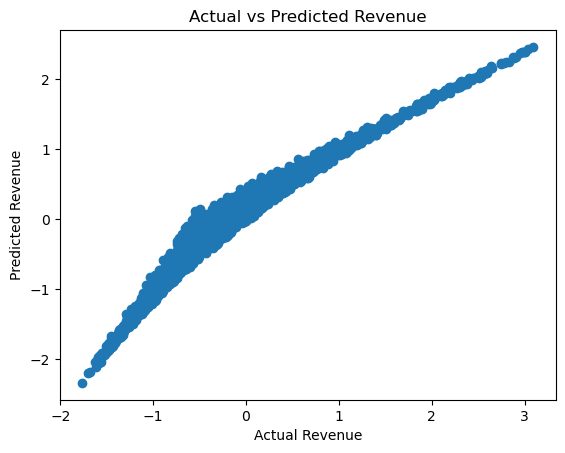

In [7]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred)
plt.xlabel('Actual Revenue')
plt.ylabel('Predicted Revenue')
plt.title('Actual vs Predicted Revenue')
plt.show()

## Pytorch

Now we do the same but using the neural network from Pytorch

In [8]:
import torch

import torch.nn as nn
import torch.optim as optim

# Define the neural network architecture
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Set the parameters
input_size = X_train.shape[1]
hidden_size = 64
output_size = 1
num_epochs = 100
learning_rate = 0.001

# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# Initialize the model, loss function, and optimizer
model = NeuralNet(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-6)

# Train the model
for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Make predictions
model.eval()
with torch.no_grad():
    y_pred_tensor = model(X_test_tensor)
    y_pred = y_pred_tensor.numpy().reshape(-1, 1)


Epoch [10/100], Loss: 0.6576
Epoch [20/100], Loss: 0.4829
Epoch [30/100], Loss: 0.3526
Epoch [40/100], Loss: 0.2508
Epoch [50/100], Loss: 0.1696
Epoch [60/100], Loss: 0.1099
Epoch [70/100], Loss: 0.0715
Epoch [80/100], Loss: 0.0492
Epoch [90/100], Loss: 0.0366
Epoch [100/100], Loss: 0.0289


Mean Squared Error: 0.028343872786932987
Mean Absolute Error: 0.13142329933020633
Mean Absolute Percentage Error: 0.8321715366195996


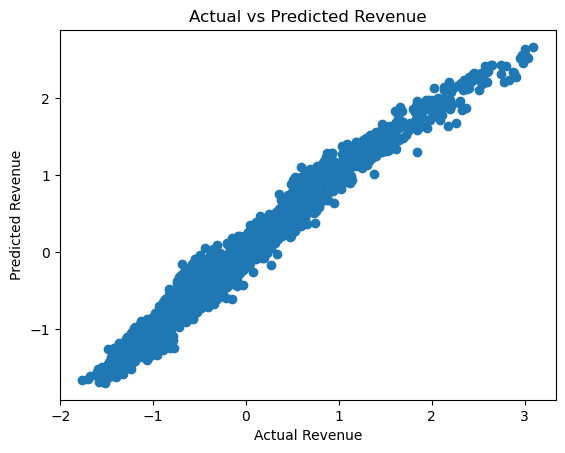

In [9]:
# Calculate and print the mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
# Calculate and print the mean absolute error
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

# Calculate the mean absolute percentage error
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"Mean Absolute Percentage Error: {mape}")

# Plot the scatter plot of actual vs predicted revenue
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Revenue')
plt.ylabel('Predicted Revenue')
plt.title('Actual vs Predicted Revenue')
plt.show()

## Conclusions

We got 8% mean absolute percentage error with multilinear regressor from Scikit and 6% MAPE with the neural network configured with Pytorch.

This is overwhelmingly better than the results gotten in the [`02-use-neural-network.ipynb`](./02-use-neural-network.ipynb), which were 23% MAPE at best.

More importantly, both these models are actually approximating the data, as could be seen on the scatterplots.
We can summarize the performance of the three models as such:

| Model | MSE  | MAE  | MAPE  |
|-------|-----:|-----:|------:|
| NeuralNet #12 (best)                  | 3.589070e+10      | 152946.486867    | 23.973530% |
| sklearn.linear_model.LinearRegression | 3199127213.975748 |  43278.690517 | 8.195097% |
| torch.nn                              | 2846126159.593153 |  39640.885824 | 6.429623% |